In [1]:
from pythainlp import thai_characters
from pythainlp.corpus import thai_stopwords
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import trange, tqdm_notebook
import numpy as np
import re
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
%matplotlib inline
from scipy.sparse import csc_matrix

In [2]:
tokens = pickle.load(open('../out/car/tokens_post.txt','rb'))

In [ ]:
# remove single character and stopwords
for i in trange(len(tokens)):
    tokens[i] = [word for word in tokens[i] if not word in thai_stopwords()]
    tokens[i] = [word for word in tokens[i] if not word in set(thai_characters)]
    tokens[i] = [word for word in tokens[i] if re.search(r'\s+',word) == None]

In [30]:
pickle.dump(tokens, open('../tmp/tokens_post_car_clean.pkl','wb'))

In [3]:
tokens = pickle.load(open('../tmp/tokens_post_car_clean.pkl', 'rb'))

In [4]:
kws = ['toyota']
kw_radius = 10
res = []
for tkns in tqdm_notebook(tokens):
    lhs_idx, rhs_idx = -np.inf, -np.inf
    for i,word in enumerate(tkns):
        if word in kws:
            sent = []
            # update the range of search index
            if min(0,i-kw_radius) < rhs_idx:
                lhs_idx = rhs_idx
            else:
                lhs_idx = max(0,i-kw_radius)

            rhs_idx = min(len(tkns)-1,i+kw_radius)

            # append result
            res.append(tkns[lhs_idx:rhs_idx+1])
            
# apply countvectorizer

# join the word
res = ['<splitter>'.join(tkns) for tkns in res]

In [84]:
# get the vector
vectorizer = CountVectorizer(tokenizer=lambda x:x.split('<splitter>'),min_df=2,max_features=75)
X = vectorizer.fit_transform(res)

X_bin = X>0
X_bin = X_bin.astype(int)

co_mat = X_bin.T*X_bin

itos = vectorizer.get_feature_names()
stoi = {v:i for i,v in enumerate(vectorizer.get_feature_names())}

# filter only kws frequency
# kws_idx = [stoi[kw] for kw in kws]
kws_mat = co_mat.copy()
kws_mat = kws_mat/kws_mat.sum(1)

In [76]:
def get_line_width(pct):
    if pct<=np.percentile(kws_mat.reshape(1,-1),33):
        return 0.5
    elif pct<=np.percentile(kws_mat.reshape(1,-1),66):
        return 1
    else:
        return 2

In [85]:
kws_mat = csc_matrix(kws_mat)

## Create graph

In [86]:
G = nx.Graph()

# add nodes
G.add_nodes_from(vectorizer.get_feature_names())

# add edges
color_gen = range(len(kws))
kws_mat_coo = kws_mat.tocoo()
for i,j,v in zip(kws_mat_coo.row, kws_mat_coo.col, kws_mat_coo.data):
    G.add_edge(itos[i], itos[j], width=get_line_width(v),color='g')
#     G.add_edge(itos[i], itos[j], width=get_line_width(v))

edge_c = [G.get_edge_data(u,v)['color'] for u,v in G.edges()]
edge_width = [G.get_edge_data(u,v)['width'] for u,v in G.edges()]

## Visualize graph

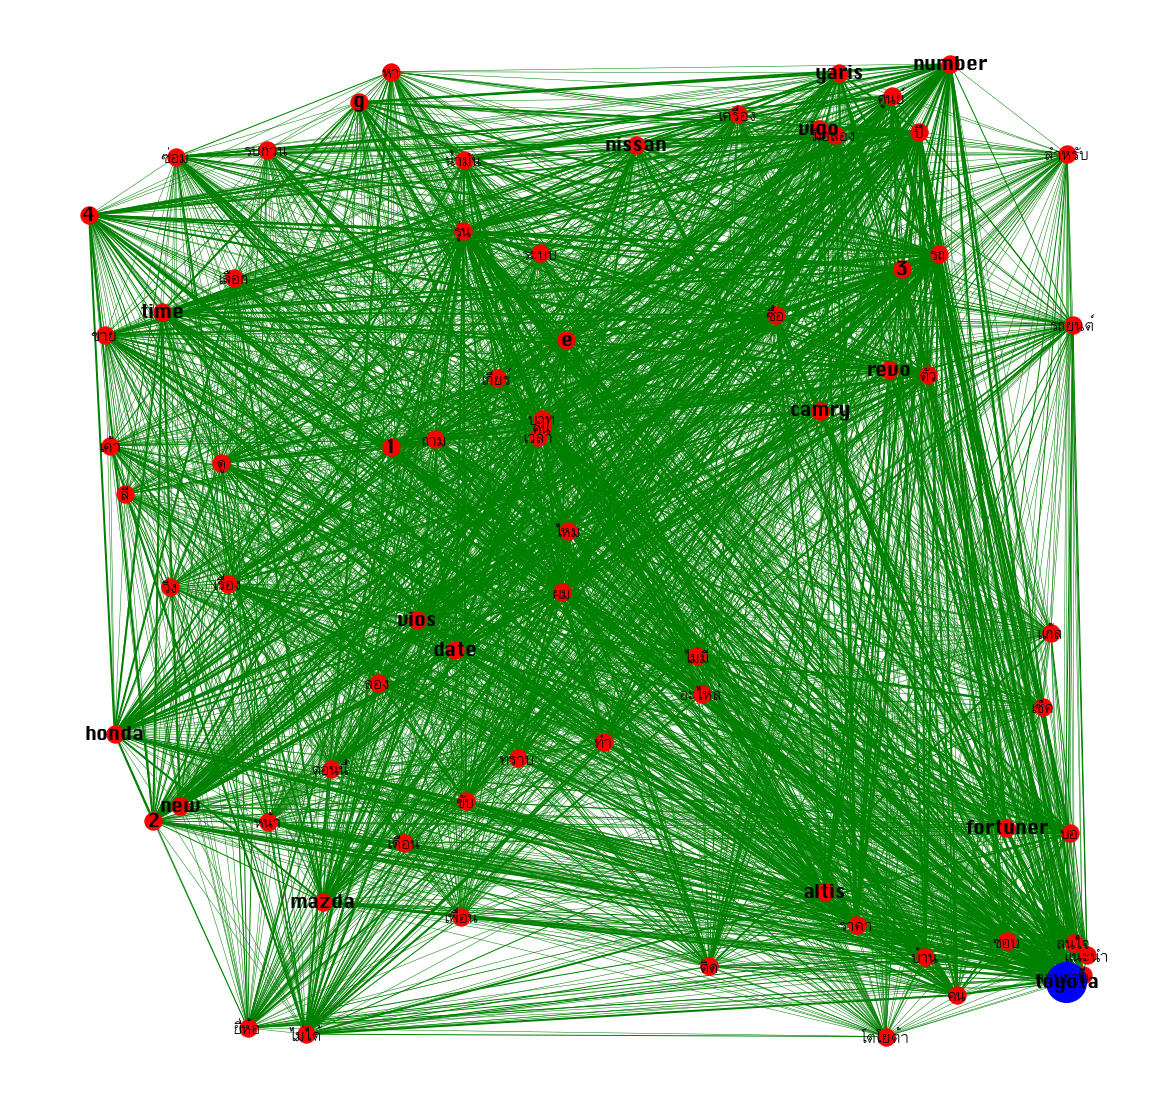

In [87]:
fig, ax = plt.subplots(figsize=(20,20))

# need some positions for the nodes, so lay it out
pos = nx.random_layout(G)
# circular_layout, random_layout, shell_layout, spring_layout, spectral_layout

nx.draw(G, pos=pos,width=edge_width ,edge_color=edge_c, edge_cmap=plt.cm.Set2)
# nx.draw_networkx_edges(G, pos=pos,width=4,edge_color='r')
labels_params = {"labels":{n: "" if n[0] == "." else n for n in G.nodes()},
                 "font_family":"Silom",
                 "alpha":1,
                 "font_size":18 }

for kw in kws:
    plt.plot(pos[kw][0],pos[kw][1],'bo',markersize=40)

nx.draw_networkx_labels(G, pos, **labels_params)

plt.show()

In [ ]:
# TO DO:
# summary statistic inc. graph stat...!!!

# top n co-occured words for each key word

# feedback:
'''
1) แยก keywords
2) อยากเห็น full relation ระหว่างแต่ละ word ใน keyword
'''